# Clustering and image segmentation

Earlier this week I wrote a post on [pitching matchups for this year's world series](https://dantegates.github.io/2019/10/22/2019-world-series-pitcher-matchups.html). As I was working on the post, I needed to remove grey backgrounds from headshots of the players so that the images wouldn't overlap in the scatter plot I was working on. During the process of removing these backgrounds I came across an application of [clustering](https://en.wikipedia.org/wiki/Cluster_analysis) that I thought was worth writing about on its own.

My first approach at removing the background was a slightly modified version of the wisdom of the sages [I found on stackoverflow](https://stackoverflow.com/questions/765736/using-pil-to-make-all-white-pixels-transparent): set the alpha channel to 0 for all pixels that are "close" to the RGB value of the first pixel. Something like this

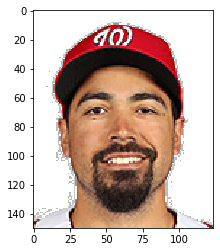

In [1]:
import urllib.request
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image


image_url = 'http://gdx.mlb.com/images/gameday/mugshots/mlb/543685@2x.jpg'

with urllib.request.urlopen(image_url) as f:
    image = Image.open(f)

image = image.convert("RGBA")
(dim2, dim1), dim3 = image.size, 4
shape = (dim1, dim2, dim3)
pixels = np.array(image.getdata())
# -1 is alpha channel
pixels[:, -1] = np.where(np.max(np.abs(pixels - pixels[0]), axis=1) <= 20, 0, 255)
plt.imshow(pixels.reshape((dim1, dim2, dim3)))

The results weren't bad but neither were they great. For the plot I was working on, though, they were good enough.

However, the next day I started thinking about other ways I could have removed the background. I seemed to recall that clustering is sometimes used for [image segmentation](https://en.wikipedia.org/wiki/Image_segmentation). I figured that I would give it a try as it seemed like something that should be easy enough to code up with `sklearn`. It turns out you can do this in less than 50 lines of code (the clustering algorithm and logic around it used to set the alpha channel is really only 3 lines of code, the rest is for plotting).

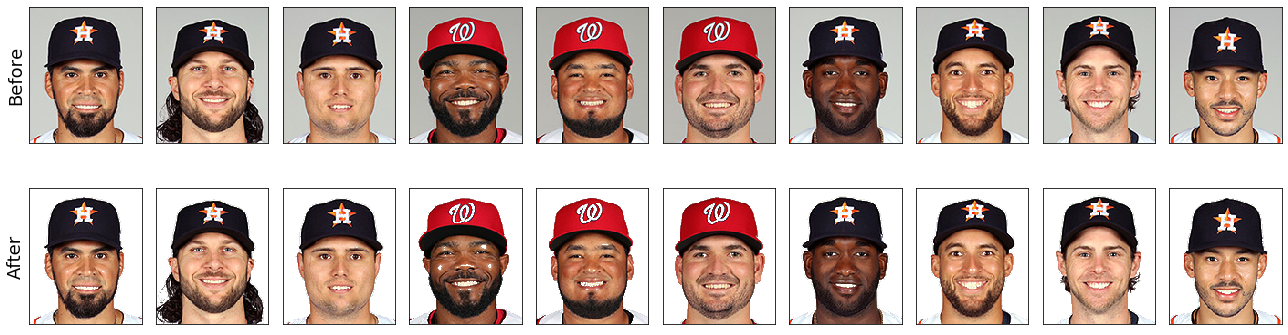

In [3]:
import matplotlib.pyplot as plt
import pandas as pd


N = 10
urls = np.random.RandomState(1).choice(pd.read_csv('matchups.csv').img.unique(), N, replace=False)

def fetch_image(url):
    with urllib.request.urlopen(url) as f:
        return Image.open(f)
    
def label_pixels(pixels):
    return KMeans().fit(pixels[:, :-1]).predict(pixels[:, :-1])

    
def set_alpha(pixels, labels, length, width):
    # we know label of first pixel represents the background
    alpha = np.where(labels == labels[0], 0, 255)
    pixels[:, -1] = alpha


f, axs = plt.subplots(2, N, figsize=(18, 7), tight_layout=True)

axs[0][0].set_ylabel('Before', fontsize=18)
axs[1][0].set_ylabel('After', fontsize=18)

for i, url in enumerate(urls):
    image = fetch_image(url)
    (dim2, dim1), dim3 = image.size, 4
    shape = (dim1, dim2, dim3)
    
    pixels = np.array(image.convert("RGBA").getdata())
    labels = label_pixels(pixels)

    axs[0][i].imshow(pixels.reshape(shape))

    set_alpha(pixels, labels, dim1, dim2)
    axs[1][i].imshow(pixels.reshape(shape))
    

# hide axes
import itertools
for ax in itertools.chain.from_iterable(axs):
    ax.grid(False)
    ax.set_xticks([])
    ax.set_yticks([])

There are three things that I really like about this solution that inspired me to write this post.

First, the results look better.

Second, it's a much more elegant solution than the one I originally hacked together. It's something that could be easily automated and doesn't require "manual iterations" of tuning the threshold of "closeness" to the first pixel, e.g. recall this code snippet from above

```python
pixels[:, -1] = np.where(np.max(np.abs(pixels - pixels[0]), axis=1) <= 20, 0, 255)
```

It took several iterations of guess and check to determine that 20 was a number that worked decently well for all players.

The third thing I like about this solution is probably the one like that most, and that is, that clustering feels very intutive here. In fact, the code I originally wrote is very similar to clustering. Although there are still some technical differences that eventually cause the analogy to break down, you could think about it as clustering with a precomputed centroid (the first pixel which I knew would be the background) and [Chebyshev distance](https://en.wikipedia.org/wiki/Chebyshev_distance) as the distance metric. It's pretty cool that the heuristic I used at first is only a few steps away from a more elegant approach leveraging machine learning.